In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import preprocessing
import glob
from scipy import stats
import datetime as dt

In [2]:
# Load data from csv 3 files
# acceleration.txt, heartrate.txt, labeled_sleep.txt
ACC = pd.read_csv('acceleration.txt', sep = ' ',names=['timedelta', 'accX', 'accY', 'accZ'])
HeartR = pd.read_csv('heartrate.txt', sep = ',',names=['timedelta', 'heartrate'])
SleepL = pd.read_csv('labeled_sleep.txt', sep = ' ',names=['timedelta', 'sleep'])

In [3]:
ACC

,timedelta,accX,accY,accZ
0,-124489.161050,0.017487,-0.586700,-0.805771
1,-124489.116395,0.018982,-0.589676,-0.809158
2,-124489.115548,0.020966,-0.580887,-0.815048
3,-124489.114691,0.019485,-0.580872,-0.813583
4,-124489.097700,0.016998,-0.587204,-0.806259
...,...,...,...,...
981995,17642.967007,0.505249,0.425720,-0.748764
981996,17642.987576,0.508194,0.429138,-0.750717
981997,17643.006946,0.508179,0.427200,-0.747284
981998,17643.026865,0.505737,0.427673,-0.749741


In [4]:
HeartR

,timedelta,heartrate
0,-556410.36066,57
1,-556408.36062,56
2,-556403.36062,56
3,-556399.36062,57
4,-556389.36062,59
...,...,...
4873,16959.47229,72
4874,16964.47229,74
4875,16970.47229,75
4876,16975.47229,76


In [5]:
SleepL

,timedelta,sleep
0,0,-1
1,30,-1
2,60,-1
3,90,-1
4,120,-1
...,...,...
562,16860,0
563,16890,0
564,16920,0
565,16950,0


In [6]:
# Check ‘timedelta’ max(), min() of ACC, HeartR, SleepL (ช่วงเวลาที่มีข้อมูลใกล้กัน)
ACC_max_date = ACC['timedelta'].max()
ACC_min_date = ACC['timedelta'].min()
HeartR_max_date = HeartR['timedelta'].max()
HeartR_min_date = HeartR['timedelta'].min()
SleepL_max_date = SleepL['timedelta'].max()
SleepL_min_date = SleepL['timedelta'].min()

In [7]:
print('ACC start: ',ACC_min_date,'ACC end: ',ACC_max_date)
print('HeartR start: ',HeartR_min_date,'HeartR end: ',HeartR_max_date)
print('SleepL start: ',SleepL_min_date,'SleepL end: ',SleepL_max_date)

ACC start:  -124489.16105 ACC end:  17643.046417
HeartR start:  -556410.36066 HeartR end:  16980.47229
SleepL start:  0 SleepL end:  16980


In [8]:
ACC_new = ACC[(ACC["timedelta"]> ACC_min_date) & (ACC["timedelta"] < ACC_max_date) & (ACC["timedelta"]> HeartR_min_date) & (ACC["timedelta"] < HeartR_max_date) &(ACC["timedelta"]> SleepL_min_date) & (ACC["timedelta"] < SleepL_max_date)]
HeartR_new = HeartR[(HeartR["timedelta"]> ACC_min_date) & (HeartR["timedelta"] < ACC_max_date) & (HeartR["timedelta"]> HeartR_min_date) & (HeartR["timedelta"] < HeartR_max_date) &(HeartR["timedelta"]> SleepL_min_date) & (HeartR["timedelta"] < SleepL_max_date)]
SleepL_new = SleepL[(SleepL["timedelta"]> ACC_min_date) & (SleepL["timedelta"] < ACC_max_date) & (SleepL["timedelta"]> HeartR_min_date) & (SleepL["timedelta"] < HeartR_max_date) &(SleepL["timedelta"]> SleepL_min_date) & (SleepL["timedelta"] < SleepL_max_date)]


In [9]:
ACC_new

,timedelta,accX,accY,accZ
98777,0.000721,-0.234650,0.905975,0.362747
98778,0.017162,-0.231232,0.893265,0.371613
98779,0.037183,-0.227814,0.915848,0.369049
98780,0.057108,-0.240524,0.919159,0.352890
98781,0.076929,-0.240448,0.889175,0.350143
...,...,...,...,...
948796,16979.905934,-0.442413,-0.527573,0.723450
948797,16979.925889,-0.441925,-0.527573,0.721985
948798,16979.945849,-0.441437,-0.526108,0.721985
948799,16979.965927,-0.443405,-0.525116,0.723434


In [10]:
HeartR_new

,timedelta,heartrate
1576,8.47840,97
1577,13.47840,95
1578,18.47840,96
1579,19.47840,95
1580,24.47840,95
...,...,...
4872,16954.47226,73
4873,16959.47229,72
4874,16964.47229,74
4875,16970.47229,75


In [11]:
SleepL

,timedelta,sleep
0,0,-1
1,30,-1
2,60,-1
3,90,-1
4,120,-1
...,...,...
562,16860,0
563,16890,0
564,16920,0
565,16950,0


In [12]:
# Convert to datetime and round to second,
ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], 'seconds').round('1s'))
HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'], 'seconds').round('1s'))
SleepL_new['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL_new['timedelta'], 'seconds').round('1s'))

C:\Users\ACER\AppData\Local\Temp\ipykernel_3780\1343708758.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], 'seconds').round('1s'))
C:\Users\ACER\AppData\Local\Temp\ipykernel_3780\1343708758.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'], 'seconds').round('1s'))
C:\Users\ACER\AppData\Local\Temp\ipykernel_3780\1343708758.py:4: SettingWithCopyWarning:

In [13]:
ACC_new

,timedelta,accX,accY,accZ
98777,0 days 00:00:00,-0.234650,0.905975,0.362747
98778,0 days 00:00:00,-0.231232,0.893265,0.371613
98779,0 days 00:00:00,-0.227814,0.915848,0.369049
98780,0 days 00:00:00,-0.240524,0.919159,0.352890
98781,0 days 00:00:00,-0.240448,0.889175,0.350143
...,...,...,...,...
948796,0 days 04:43:00,-0.442413,-0.527573,0.723450
948797,0 days 04:43:00,-0.441925,-0.527573,0.721985
948798,0 days 04:43:00,-0.441437,-0.526108,0.721985
948799,0 days 04:43:00,-0.443405,-0.525116,0.723434


In [14]:
# Average rounding duplicated time
df_acc_X = ACC_new.groupby('timedelta')['accX'].mean()
df_acc_Y = ACC_new.groupby('timedelta')['accY'].mean()
df_acc_Z = ACC_new.groupby('timedelta')['accZ'].mean()

In [15]:
ACC_new_2 = pd.concat([df_acc_X, df_acc_Y, df_acc_Z], axis=1).reset_index()

In [16]:
ACC_new_2

,timedelta,accX,accY,accZ
0,0 days 00:00:00,-0.243203,0.895372,0.367591
1,0 days 00:00:01,-0.240757,0.873826,0.415446
2,0 days 00:00:02,-0.244620,0.883943,0.387026
3,0 days 00:00:03,-0.248036,0.902427,0.347812
4,0 days 00:00:04,-0.241778,0.912946,0.321502
...,...,...,...,...
16976,0 days 04:42:56,-0.442763,-0.525892,0.722950
16977,0 days 04:42:57,-0.441990,-0.525476,0.723410
16978,0 days 04:42:58,-0.441581,-0.525116,0.724003
16979,0 days 04:42:59,-0.442283,-0.525849,0.723265


In [17]:
ACC_new_2['timedelta'] = ACC_new_2['timedelta'] - ACC_new_2['timedelta'].min()
ACC_new_2

,timedelta,accX,accY,accZ
0,0 days 00:00:00,-0.243203,0.895372,0.367591
1,0 days 00:00:01,-0.240757,0.873826,0.415446
2,0 days 00:00:02,-0.244620,0.883943,0.387026
3,0 days 00:00:03,-0.248036,0.902427,0.347812
4,0 days 00:00:04,-0.241778,0.912946,0.321502
...,...,...,...,...
16976,0 days 04:42:56,-0.442763,-0.525892,0.722950
16977,0 days 04:42:57,-0.441990,-0.525476,0.723410
16978,0 days 04:42:58,-0.441581,-0.525116,0.724003
16979,0 days 04:42:59,-0.442283,-0.525849,0.723265


In [18]:
resample_rule = '1s'
HeartR_new2 = HeartR_new.set_index('timedelta').resample(resample_rule,).median().ffill()
HeartR_new2

,heartrate
timedelta,
0 days 00:00:08,97.0
0 days 00:00:09,97.0
0 days 00:00:10,97.0
0 days 00:00:11,97.0
0 days 00:00:12,97.0
...,...
0 days 04:42:51,75.0
0 days 04:42:52,75.0
0 days 04:42:53,75.0


In [19]:
df_heartrate = HeartR_new.groupby('timedelta')['heartrate'].mean()
#Resampling every 1s with median with ffill
HeartR_new_2 = pd.concat([df_heartrate], axis=1).reset_index()
HeartR_new_2['timedelta'] = HeartR_new_2['timedelta']-HeartR_new_2['timedelta'].min()
HeartR_new_2


,timedelta,heartrate
0,0 days 00:00:00,97.0
1,0 days 00:00:05,95.0
2,0 days 00:00:10,96.0
3,0 days 00:00:11,95.0
4,0 days 00:00:16,95.0
...,...,...
3296,0 days 04:42:26,73.0
3297,0 days 04:42:31,72.0
3298,0 days 04:42:36,74.0
3299,0 days 04:42:42,75.0


In [20]:
resample_rule = '1s'
SleepL_new2 = SleepL_new.set_index('timedelta').resample(resample_rule,).median().ffill()
SleepL_new2

,sleep
timedelta,
0 days 00:00:30,-1.0
0 days 00:00:31,-1.0
0 days 00:00:32,-1.0
0 days 00:00:33,-1.0
0 days 00:00:34,-1.0
...,...
0 days 04:42:26,0.0
0 days 04:42:27,0.0
0 days 04:42:28,0.0


In [21]:
df_SleepL = SleepL_new.groupby('timedelta')['sleep'].mean()
SleepL_new_2 = pd.concat([df_SleepL], axis=1).reset_index()
SleepL_new_2['timedelta'] = SleepL_new_2['timedelta']-SleepL_new_2['timedelta'].min()
SleepL_new_2

,timedelta,sleep
0,0 days 00:00:00,-1.0
1,0 days 00:00:30,-1.0
2,0 days 00:01:00,-1.0
3,0 days 00:01:30,-1.0
4,0 days 00:02:00,-1.0
...,...,...
560,0 days 04:40:00,0.0
561,0 days 04:40:30,0.0
562,0 days 04:41:00,0.0
563,0 days 04:41:30,0.0


In [22]:
# ------------Merge All Data -------------------------------
df_all = []
df_all = pd.merge_asof(ACC_new_2, HeartR_new_2, on='timedelta')
df_all = pd.merge_asof(df_all, SleepL_new_2, on = 'timedelta')
df_all

,timedelta,accX,accY,accZ,heartrate,sleep
0,0 days 00:00:00,-0.243203,0.895372,0.367591,97.0,-1.0
1,0 days 00:00:01,-0.240757,0.873826,0.415446,97.0,-1.0
2,0 days 00:00:02,-0.244620,0.883943,0.387026,97.0,-1.0
3,0 days 00:00:03,-0.248036,0.902427,0.347812,97.0,-1.0
4,0 days 00:00:04,-0.241778,0.912946,0.321502,97.0,-1.0
...,...,...,...,...,...,...
16976,0 days 04:42:56,-0.442763,-0.525892,0.722950,76.0,0.0
16977,0 days 04:42:57,-0.441990,-0.525476,0.723410,76.0,0.0
16978,0 days 04:42:58,-0.441581,-0.525116,0.724003,76.0,0.0
16979,0 days 04:42:59,-0.442283,-0.525849,0.723265,76.0,0.0


In [23]:
df_all['heartrate'].fillna(df_all['heartrate'].median())
df_all['sleep'].fillna(0)
df_all = df_all.drop(columns='timedelta')

In [24]:
df_all

,accX,accY,accZ,heartrate,sleep
0,-0.243203,0.895372,0.367591,97.0,-1.0
1,-0.240757,0.873826,0.415446,97.0,-1.0
2,-0.244620,0.883943,0.387026,97.0,-1.0
3,-0.248036,0.902427,0.347812,97.0,-1.0
4,-0.241778,0.912946,0.321502,97.0,-1.0
...,...,...,...,...,...
16976,-0.442763,-0.525892,0.722950,76.0,0.0
16977,-0.441990,-0.525476,0.723410,76.0,0.0
16978,-0.441581,-0.525116,0.724003,76.0,0.0
16979,-0.442283,-0.525849,0.723265,76.0,0.0


In [25]:
feature_columns = ['accX', 'accY', 'accZ', 'heartrate']
label_columns = ['sleep']
df_feature = df_all[feature_columns]
scaler = preprocessing.StandardScaler()
df_feature = pd.DataFrame(scaler.fit_transform(df_feature.values),index = df_feature.index,columns=df_feature.columns)
df_label = df_all[label_columns]

In [26]:
df_feature

,accX,accY,accZ,heartrate
0,-0.587547,3.058075,0.698728,2.078705
1,-0.581456,2.995094,0.757746,2.078705
2,-0.591075,3.024668,0.722696,2.078705
3,-0.599581,3.078699,0.674335,2.078705
4,-0.583998,3.109450,0.641889,2.078705
...,...,...,...,...
16976,-1.084456,-1.096565,1.136974,-0.630035
16977,-1.082531,-1.095348,1.137542,-0.630035
16978,-1.081511,-1.094296,1.138273,-0.630035
16979,-1.083260,-1.096440,1.137363,-0.630035


In [27]:
df_label

,sleep
0,-1.0
1,-1.0
2,-1.0
3,-1.0
4,-1.0
...,...
16976,0.0
16977,0.0
16978,0.0
16979,0.0


<AxesSubplot:>

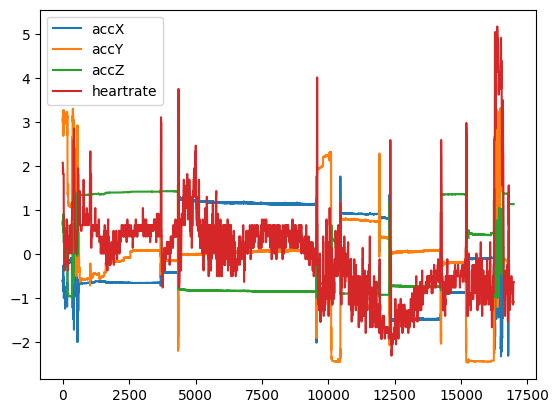

In [28]:
df_feature.plot.line()

<AxesSubplot:>

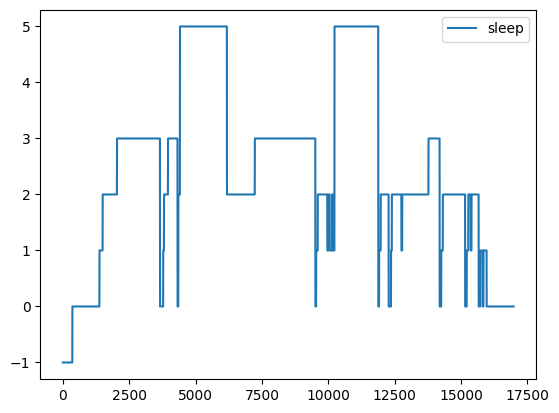

In [29]:
df_label.plot.line()

In [30]:
X = df_feature
X

,accX,accY,accZ,heartrate
0,-0.587547,3.058075,0.698728,2.078705
1,-0.581456,2.995094,0.757746,2.078705
2,-0.591075,3.024668,0.722696,2.078705
3,-0.599581,3.078699,0.674335,2.078705
4,-0.583998,3.109450,0.641889,2.078705
...,...,...,...,...
16976,-1.084456,-1.096565,1.136974,-0.630035
16977,-1.082531,-1.095348,1.137542,-0.630035
16978,-1.081511,-1.094296,1.138273,-0.630035
16979,-1.083260,-1.096440,1.137363,-0.630035


In [31]:
Y = df_label
Y

,sleep
0,-1.0
1,-1.0
2,-1.0
3,-1.0
4,-1.0
...,...
16976,0.0
16977,0.0
16978,0.0
16979,0.0


In [32]:
# Train Test Split
seed = 42
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.3, random_state=seed)

In [33]:
# Model Traing Parameter
# Create SVC model
c_val = 100 
gmm =0.1
d = 2
# Model initialize
svc_lin = SVC(kernel='linear', C=c_val)
svc_rbf = SVC(kernel='rbf', C=c_val, gamma=gmm)
svc_poly = SVC(kernel='poly', C=c_val, degree = d)

In [34]:
svc_rbf = svc_rbf.fit(X_train, Y_train)
svc_poly = svc_poly.fit(X_train, Y_train)

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [35]:
svc_rbf_pred = svc_rbf.predict(X_test)
svc_poly_pred = svc_poly.predict(X_test)

In [36]:
# Print Confusion Matrix and Classification Report for best k
print('Confusion Matrix of SVC_RBF: ')
print(confusion_matrix(Y_test, svc_rbf_pred))
print('Classification Report of SVC_RBF: ')
print(classification_report(Y_test, svc_rbf_pred))

Confusion Matrix of SVC_RBF: 
[[ 115    0    0    0    0    0]
 [   7  518   16  157   34    9]
 [   0   71   68   92    3   11]
 [   0   55   17 1332   86   32]
 [   0    0    0   64 1395    0]
 [   0    2    0  157    0  854]]
Classification Report of SVC_RBF: 
              precision    recall  f1-score   support

        -1.0       0.94      1.00      0.97       115
         0.0       0.80      0.70      0.75       741
         1.0       0.67      0.28      0.39       245
         2.0       0.74      0.88      0.80      1522
         3.0       0.92      0.96      0.94      1459
         5.0       0.94      0.84      0.89      1013

    accuracy                           0.84      5095
   macro avg       0.84      0.78      0.79      5095
weighted avg       0.84      0.84      0.83      5095



In [37]:
# Print Confusion Matrix and Classification Report for best k
print('Confusion Matrix of SVC_RBF: ')
print(confusion_matrix(Y_test, svc_poly_pred))
print('Classification Report of SVC_RBF: ')
print(classification_report(Y_test, svc_poly_pred))

Confusion Matrix of SVC_RBF: 
[[ 115    0    0    0    0    0]
 [  10  510  119   70   20   12]
 [   3   59   87   78    4   14]
 [   0   65  101 1098  152  106]
 [   0   31    0  158 1270    0]
 [   0    0    0  105    0  908]]
Classification Report of SVC_RBF: 
              precision    recall  f1-score   support

        -1.0       0.90      1.00      0.95       115
         0.0       0.77      0.69      0.73       741
         1.0       0.28      0.36      0.32       245
         2.0       0.73      0.72      0.72      1522
         3.0       0.88      0.87      0.87      1459
         5.0       0.87      0.90      0.88      1013

    accuracy                           0.78      5095
   macro avg       0.74      0.76      0.75      5095
weighted avg       0.79      0.78      0.78      5095



In [38]:
#Create Model Parameter Dictionary for SVC
kernel = ['rbf']
C_list = [0.1, 1.0, 10.0, 100.0, 200.0, 500.0]
Gamma_list = [0.01, 0.1, 1.0, 10]
d_list = [2, 3]
params = dict(kernel = kernel,C = C_list,gamma = Gamma_list,degree = d_list)

In [39]:
# Perform GridsearchCV() for each classification model
grid = GridSearchCV( estimator=  SVC(), n_jobs = 1, verbose = 10, scoring = 'accuracy', cv = 2, param_grid = params)
grid_result = grid.fit(X_train, Y_train)


Fitting 2 folds for each of 48 candidates, totalling 96 fits
[CV 1/2; 1/48] START C=0.1, degree=2, gamma=0.01, kernel=rbf....................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 1/48] END C=0.1, degree=2, gamma=0.01, kernel=rbf;, score=0.501 total time=   6.0s
[CV 2/2; 1/48] START C=0.1, degree=2, gamma=0.01, kernel=rbf....................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 1/48] END C=0.1, degree=2, gamma=0.01, kernel=rbf;, score=0.498 total time=   5.9s
[CV 1/2; 2/48] START C=0.1, degree=2, gamma=0.1, kernel=rbf.....................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 2/48] END C=0.1, degree=2, gamma=0.1, kernel=rbf;, score=0.622 total time=   4.8s
[CV 2/2; 2/48] START C=0.1, degree=2, gamma=0.1, kernel=rbf.....................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 2/48] END C=0.1, degree=2, gamma=0.1, kernel=rbf;, score=0.629 total time=   4.7s
[CV 1/2; 3/48] START C=0.1, degree=2, gamma=1.0, kernel=rbf.....................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 3/48] END C=0.1, degree=2, gamma=1.0, kernel=rbf;, score=0.725 total time=   3.8s
[CV 2/2; 3/48] START C=0.1, degree=2, gamma=1.0, kernel=rbf.....................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 3/48] END C=0.1, degree=2, gamma=1.0, kernel=rbf;, score=0.728 total time=   3.7s
[CV 1/2; 4/48] START C=0.1, degree=2, gamma=10, kernel=rbf......................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 4/48] END C=0.1, degree=2, gamma=10, kernel=rbf;, score=0.768 total time=   3.4s
[CV 2/2; 4/48] START C=0.1, degree=2, gamma=10, kernel=rbf......................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 4/48] END C=0.1, degree=2, gamma=10, kernel=rbf;, score=0.784 total time=   3.4s
[CV 1/2; 5/48] START C=0.1, degree=3, gamma=0.01, kernel=rbf....................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 5/48] END C=0.1, degree=3, gamma=0.01, kernel=rbf;, score=0.501 total time=   7.3s
[CV 2/2; 5/48] START C=0.1, degree=3, gamma=0.01, kernel=rbf....................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 5/48] END C=0.1, degree=3, gamma=0.01, kernel=rbf;, score=0.498 total time=   5.7s
[CV 1/2; 6/48] START C=0.1, degree=3, gamma=0.1, kernel=rbf.....................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 6/48] END C=0.1, degree=3, gamma=0.1, kernel=rbf;, score=0.622 total time=   6.0s
[CV 2/2; 6/48] START C=0.1, degree=3, gamma=0.1, kernel=rbf.....................
[CV 2/2; 6/48] END C=0.1, degree=3, gamma=0.1, kernel=rbf;, score=0.629 total time=   5.0s
[CV 1/2; 7/48] START C=0.1, degree=3, gamma=1.0, kernel=rbf.....................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 7/48] END C=0.1, degree=3, gamma=1.0, kernel=rbf;, score=0.725 total time=   3.8s
[CV 2/2; 7/48] START C=0.1, degree=3, gamma=1.0, kernel=rbf.....................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 7/48] END C=0.1, degree=3, gamma=1.0, kernel=rbf;, score=0.728 total time=   3.7s
[CV 1/2; 8/48] START C=0.1, degree=3, gamma=10, kernel=rbf......................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 8/48] END C=0.1, degree=3, gamma=10, kernel=rbf;, score=0.768 total time=   3.5s
[CV 2/2; 8/48] START C=0.1, degree=3, gamma=10, kernel=rbf......................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 8/48] END C=0.1, degree=3, gamma=10, kernel=rbf;, score=0.784 total time=   3.5s
[CV 1/2; 9/48] START C=1.0, degree=2, gamma=0.01, kernel=rbf....................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 9/48] END C=1.0, degree=2, gamma=0.01, kernel=rbf;, score=0.527 total time=   5.1s
[CV 2/2; 9/48] START C=1.0, degree=2, gamma=0.01, kernel=rbf....................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 9/48] END C=1.0, degree=2, gamma=0.01, kernel=rbf;, score=0.541 total time=   5.1s
[CV 1/2; 10/48] START C=1.0, degree=2, gamma=0.1, kernel=rbf....................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 10/48] END C=1.0, degree=2, gamma=0.1, kernel=rbf;, score=0.712 total time=   5.1s
[CV 2/2; 10/48] START C=1.0, degree=2, gamma=0.1, kernel=rbf....................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 10/48] END C=1.0, degree=2, gamma=0.1, kernel=rbf;, score=0.721 total time=   5.0s
[CV 1/2; 11/48] START C=1.0, degree=2, gamma=1.0, kernel=rbf....................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 11/48] END C=1.0, degree=2, gamma=1.0, kernel=rbf;, score=0.785 total time=   4.2s
[CV 2/2; 11/48] START C=1.0, degree=2, gamma=1.0, kernel=rbf....................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 11/48] END C=1.0, degree=2, gamma=1.0, kernel=rbf;, score=0.792 total time=   4.2s
[CV 1/2; 12/48] START C=1.0, degree=2, gamma=10, kernel=rbf.....................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 12/48] END C=1.0, degree=2, gamma=10, kernel=rbf;, score=0.856 total time=   3.7s
[CV 2/2; 12/48] START C=1.0, degree=2, gamma=10, kernel=rbf.....................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 12/48] END C=1.0, degree=2, gamma=10, kernel=rbf;, score=0.862 total time=   4.0s
[CV 1/2; 13/48] START C=1.0, degree=3, gamma=0.01, kernel=rbf...................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 13/48] END C=1.0, degree=3, gamma=0.01, kernel=rbf;, score=0.527 total time=   7.3s
[CV 2/2; 13/48] START C=1.0, degree=3, gamma=0.01, kernel=rbf...................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 13/48] END C=1.0, degree=3, gamma=0.01, kernel=rbf;, score=0.541 total time=   7.0s
[CV 1/2; 14/48] START C=1.0, degree=3, gamma=0.1, kernel=rbf....................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 14/48] END C=1.0, degree=3, gamma=0.1, kernel=rbf;, score=0.712 total time=   5.2s
[CV 2/2; 14/48] START C=1.0, degree=3, gamma=0.1, kernel=rbf....................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 14/48] END C=1.0, degree=3, gamma=0.1, kernel=rbf;, score=0.721 total time=   4.5s
[CV 1/2; 15/48] START C=1.0, degree=3, gamma=1.0, kernel=rbf....................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 15/48] END C=1.0, degree=3, gamma=1.0, kernel=rbf;, score=0.785 total time=   3.5s
[CV 2/2; 15/48] START C=1.0, degree=3, gamma=1.0, kernel=rbf....................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 15/48] END C=1.0, degree=3, gamma=1.0, kernel=rbf;, score=0.792 total time=   3.5s
[CV 1/2; 16/48] START C=1.0, degree=3, gamma=10, kernel=rbf.....................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 16/48] END C=1.0, degree=3, gamma=10, kernel=rbf;, score=0.856 total time=   3.5s
[CV 2/2; 16/48] START C=1.0, degree=3, gamma=10, kernel=rbf.....................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 16/48] END C=1.0, degree=3, gamma=10, kernel=rbf;, score=0.862 total time=   2.6s
[CV 1/2; 17/48] START C=10.0, degree=2, gamma=0.01, kernel=rbf..................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 17/48] END C=10.0, degree=2, gamma=0.01, kernel=rbf;, score=0.679 total time=   5.5s
[CV 2/2; 17/48] START C=10.0, degree=2, gamma=0.01, kernel=rbf..................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 17/48] END C=10.0, degree=2, gamma=0.01, kernel=rbf;, score=0.669 total time=   6.6s
[CV 1/2; 18/48] START C=10.0, degree=2, gamma=0.1, kernel=rbf...................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 18/48] END C=10.0, degree=2, gamma=0.1, kernel=rbf;, score=0.764 total time=   3.6s
[CV 2/2; 18/48] START C=10.0, degree=2, gamma=0.1, kernel=rbf...................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 18/48] END C=10.0, degree=2, gamma=0.1, kernel=rbf;, score=0.764 total time=   3.6s
[CV 1/2; 19/48] START C=10.0, degree=2, gamma=1.0, kernel=rbf...................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 19/48] END C=10.0, degree=2, gamma=1.0, kernel=rbf;, score=0.849 total time=   2.7s
[CV 2/2; 19/48] START C=10.0, degree=2, gamma=1.0, kernel=rbf...................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 19/48] END C=10.0, degree=2, gamma=1.0, kernel=rbf;, score=0.856 total time=   2.8s
[CV 1/2; 20/48] START C=10.0, degree=2, gamma=10, kernel=rbf....................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 20/48] END C=10.0, degree=2, gamma=10, kernel=rbf;, score=0.894 total time=   2.5s
[CV 2/2; 20/48] START C=10.0, degree=2, gamma=10, kernel=rbf....................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 20/48] END C=10.0, degree=2, gamma=10, kernel=rbf;, score=0.886 total time=   2.5s
[CV 1/2; 21/48] START C=10.0, degree=3, gamma=0.01, kernel=rbf..................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 21/48] END C=10.0, degree=3, gamma=0.01, kernel=rbf;, score=0.679 total time=   5.5s
[CV 2/2; 21/48] START C=10.0, degree=3, gamma=0.01, kernel=rbf..................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 21/48] END C=10.0, degree=3, gamma=0.01, kernel=rbf;, score=0.669 total time=   5.4s
[CV 1/2; 22/48] START C=10.0, degree=3, gamma=0.1, kernel=rbf...................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 22/48] END C=10.0, degree=3, gamma=0.1, kernel=rbf;, score=0.764 total time=   3.6s
[CV 2/2; 22/48] START C=10.0, degree=3, gamma=0.1, kernel=rbf...................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 22/48] END C=10.0, degree=3, gamma=0.1, kernel=rbf;, score=0.764 total time=   3.9s
[CV 1/2; 23/48] START C=10.0, degree=3, gamma=1.0, kernel=rbf...................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 23/48] END C=10.0, degree=3, gamma=1.0, kernel=rbf;, score=0.849 total time=   2.8s
[CV 2/2; 23/48] START C=10.0, degree=3, gamma=1.0, kernel=rbf...................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 23/48] END C=10.0, degree=3, gamma=1.0, kernel=rbf;, score=0.856 total time=   3.0s
[CV 1/2; 24/48] START C=10.0, degree=3, gamma=10, kernel=rbf....................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 24/48] END C=10.0, degree=3, gamma=10, kernel=rbf;, score=0.894 total time=   2.1s
[CV 2/2; 24/48] START C=10.0, degree=3, gamma=10, kernel=rbf....................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 24/48] END C=10.0, degree=3, gamma=10, kernel=rbf;, score=0.886 total time=   2.2s
[CV 1/2; 25/48] START C=100.0, degree=2, gamma=0.01, kernel=rbf.................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 25/48] END C=100.0, degree=2, gamma=0.01, kernel=rbf;, score=0.726 total time=   4.0s
[CV 2/2; 25/48] START C=100.0, degree=2, gamma=0.01, kernel=rbf.................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 25/48] END C=100.0, degree=2, gamma=0.01, kernel=rbf;, score=0.736 total time=   3.9s
[CV 1/2; 26/48] START C=100.0, degree=2, gamma=0.1, kernel=rbf..................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 26/48] END C=100.0, degree=2, gamma=0.1, kernel=rbf;, score=0.814 total time=   2.9s
[CV 2/2; 26/48] START C=100.0, degree=2, gamma=0.1, kernel=rbf..................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 26/48] END C=100.0, degree=2, gamma=0.1, kernel=rbf;, score=0.821 total time=   2.7s
[CV 1/2; 27/48] START C=100.0, degree=2, gamma=1.0, kernel=rbf..................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 27/48] END C=100.0, degree=2, gamma=1.0, kernel=rbf;, score=0.884 total time=   2.0s
[CV 2/2; 27/48] START C=100.0, degree=2, gamma=1.0, kernel=rbf..................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 27/48] END C=100.0, degree=2, gamma=1.0, kernel=rbf;, score=0.886 total time=   2.1s
[CV 1/2; 28/48] START C=100.0, degree=2, gamma=10, kernel=rbf...................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 28/48] END C=100.0, degree=2, gamma=10, kernel=rbf;, score=0.914 total time=   2.0s
[CV 2/2; 28/48] START C=100.0, degree=2, gamma=10, kernel=rbf...................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 28/48] END C=100.0, degree=2, gamma=10, kernel=rbf;, score=0.908 total time=   2.2s
[CV 1/2; 29/48] START C=100.0, degree=3, gamma=0.01, kernel=rbf.................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 29/48] END C=100.0, degree=3, gamma=0.01, kernel=rbf;, score=0.726 total time=   3.9s
[CV 2/2; 29/48] START C=100.0, degree=3, gamma=0.01, kernel=rbf.................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 29/48] END C=100.0, degree=3, gamma=0.01, kernel=rbf;, score=0.736 total time=   3.9s
[CV 1/2; 30/48] START C=100.0, degree=3, gamma=0.1, kernel=rbf..................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 30/48] END C=100.0, degree=3, gamma=0.1, kernel=rbf;, score=0.814 total time=   2.7s
[CV 2/2; 30/48] START C=100.0, degree=3, gamma=0.1, kernel=rbf..................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 30/48] END C=100.0, degree=3, gamma=0.1, kernel=rbf;, score=0.821 total time=   2.8s
[CV 1/2; 31/48] START C=100.0, degree=3, gamma=1.0, kernel=rbf..................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 31/48] END C=100.0, degree=3, gamma=1.0, kernel=rbf;, score=0.884 total time=   2.1s
[CV 2/2; 31/48] START C=100.0, degree=3, gamma=1.0, kernel=rbf..................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 31/48] END C=100.0, degree=3, gamma=1.0, kernel=rbf;, score=0.886 total time=   2.1s
[CV 1/2; 32/48] START C=100.0, degree=3, gamma=10, kernel=rbf...................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 32/48] END C=100.0, degree=3, gamma=10, kernel=rbf;, score=0.914 total time=   1.9s
[CV 2/2; 32/48] START C=100.0, degree=3, gamma=10, kernel=rbf...................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 32/48] END C=100.0, degree=3, gamma=10, kernel=rbf;, score=0.908 total time=   2.0s
[CV 1/2; 33/48] START C=200.0, degree=2, gamma=0.01, kernel=rbf.................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 33/48] END C=200.0, degree=2, gamma=0.01, kernel=rbf;, score=0.741 total time=   3.7s
[CV 2/2; 33/48] START C=200.0, degree=2, gamma=0.01, kernel=rbf.................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 33/48] END C=200.0, degree=2, gamma=0.01, kernel=rbf;, score=0.748 total time=   4.2s
[CV 1/2; 34/48] START C=200.0, degree=2, gamma=0.1, kernel=rbf..................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 34/48] END C=200.0, degree=2, gamma=0.1, kernel=rbf;, score=0.826 total time=   3.2s
[CV 2/2; 34/48] START C=200.0, degree=2, gamma=0.1, kernel=rbf..................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 34/48] END C=200.0, degree=2, gamma=0.1, kernel=rbf;, score=0.836 total time=   3.3s
[CV 1/2; 35/48] START C=200.0, degree=2, gamma=1.0, kernel=rbf..................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 35/48] END C=200.0, degree=2, gamma=1.0, kernel=rbf;, score=0.894 total time=   2.4s
[CV 2/2; 35/48] START C=200.0, degree=2, gamma=1.0, kernel=rbf..................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 35/48] END C=200.0, degree=2, gamma=1.0, kernel=rbf;, score=0.890 total time=   2.3s
[CV 1/2; 36/48] START C=200.0, degree=2, gamma=10, kernel=rbf...................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 36/48] END C=200.0, degree=2, gamma=10, kernel=rbf;, score=0.917 total time=   2.3s
[CV 2/2; 36/48] START C=200.0, degree=2, gamma=10, kernel=rbf...................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 36/48] END C=200.0, degree=2, gamma=10, kernel=rbf;, score=0.909 total time=   2.3s
[CV 1/2; 37/48] START C=200.0, degree=3, gamma=0.01, kernel=rbf.................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 37/48] END C=200.0, degree=3, gamma=0.01, kernel=rbf;, score=0.741 total time=   3.9s
[CV 2/2; 37/48] START C=200.0, degree=3, gamma=0.01, kernel=rbf.................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 37/48] END C=200.0, degree=3, gamma=0.01, kernel=rbf;, score=0.748 total time=   3.8s
[CV 1/2; 38/48] START C=200.0, degree=3, gamma=0.1, kernel=rbf..................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 38/48] END C=200.0, degree=3, gamma=0.1, kernel=rbf;, score=0.826 total time=   2.7s
[CV 2/2; 38/48] START C=200.0, degree=3, gamma=0.1, kernel=rbf..................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 38/48] END C=200.0, degree=3, gamma=0.1, kernel=rbf;, score=0.836 total time=   2.6s
[CV 1/2; 39/48] START C=200.0, degree=3, gamma=1.0, kernel=rbf..................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 39/48] END C=200.0, degree=3, gamma=1.0, kernel=rbf;, score=0.894 total time=   2.0s
[CV 2/2; 39/48] START C=200.0, degree=3, gamma=1.0, kernel=rbf..................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 39/48] END C=200.0, degree=3, gamma=1.0, kernel=rbf;, score=0.890 total time=   2.1s
[CV 1/2; 40/48] START C=200.0, degree=3, gamma=10, kernel=rbf...................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 40/48] END C=200.0, degree=3, gamma=10, kernel=rbf;, score=0.917 total time=   1.9s
[CV 2/2; 40/48] START C=200.0, degree=3, gamma=10, kernel=rbf...................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 40/48] END C=200.0, degree=3, gamma=10, kernel=rbf;, score=0.909 total time=   1.9s
[CV 1/2; 41/48] START C=500.0, degree=2, gamma=0.01, kernel=rbf.................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 41/48] END C=500.0, degree=2, gamma=0.01, kernel=rbf;, score=0.770 total time=   3.5s
[CV 2/2; 41/48] START C=500.0, degree=2, gamma=0.01, kernel=rbf.................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 41/48] END C=500.0, degree=2, gamma=0.01, kernel=rbf;, score=0.771 total time=   3.7s
[CV 1/2; 42/48] START C=500.0, degree=2, gamma=0.1, kernel=rbf..................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 42/48] END C=500.0, degree=2, gamma=0.1, kernel=rbf;, score=0.837 total time=   2.6s
[CV 2/2; 42/48] START C=500.0, degree=2, gamma=0.1, kernel=rbf..................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 42/48] END C=500.0, degree=2, gamma=0.1, kernel=rbf;, score=0.849 total time=   2.7s
[CV 1/2; 43/48] START C=500.0, degree=2, gamma=1.0, kernel=rbf..................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 43/48] END C=500.0, degree=2, gamma=1.0, kernel=rbf;, score=0.900 total time=   2.1s
[CV 2/2; 43/48] START C=500.0, degree=2, gamma=1.0, kernel=rbf..................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 43/48] END C=500.0, degree=2, gamma=1.0, kernel=rbf;, score=0.898 total time=   2.0s
[CV 1/2; 44/48] START C=500.0, degree=2, gamma=10, kernel=rbf...................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 44/48] END C=500.0, degree=2, gamma=10, kernel=rbf;, score=0.925 total time=   1.9s
[CV 2/2; 44/48] START C=500.0, degree=2, gamma=10, kernel=rbf...................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 44/48] END C=500.0, degree=2, gamma=10, kernel=rbf;, score=0.916 total time=   1.9s
[CV 1/2; 45/48] START C=500.0, degree=3, gamma=0.01, kernel=rbf.................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 45/48] END C=500.0, degree=3, gamma=0.01, kernel=rbf;, score=0.770 total time=   3.5s
[CV 2/2; 45/48] START C=500.0, degree=3, gamma=0.01, kernel=rbf.................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 45/48] END C=500.0, degree=3, gamma=0.01, kernel=rbf;, score=0.771 total time=   3.5s
[CV 1/2; 46/48] START C=500.0, degree=3, gamma=0.1, kernel=rbf..................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 46/48] END C=500.0, degree=3, gamma=0.1, kernel=rbf;, score=0.837 total time=   2.6s
[CV 2/2; 46/48] START C=500.0, degree=3, gamma=0.1, kernel=rbf..................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 46/48] END C=500.0, degree=3, gamma=0.1, kernel=rbf;, score=0.849 total time=   2.7s
[CV 1/2; 47/48] START C=500.0, degree=3, gamma=1.0, kernel=rbf..................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 47/48] END C=500.0, degree=3, gamma=1.0, kernel=rbf;, score=0.900 total time=   2.1s
[CV 2/2; 47/48] START C=500.0, degree=3, gamma=1.0, kernel=rbf..................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 47/48] END C=500.0, degree=3, gamma=1.0, kernel=rbf;, score=0.898 total time=   2.1s
[CV 1/2; 48/48] START C=500.0, degree=3, gamma=10, kernel=rbf...................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 48/48] END C=500.0, degree=3, gamma=10, kernel=rbf;, score=0.925 total time=   2.1s
[CV 2/2; 48/48] START C=500.0, degree=3, gamma=10, kernel=rbf...................


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 48/48] END C=500.0, degree=3, gamma=10, kernel=rbf;, score=0.916 total time=   2.3s


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [42]:
print('Best params : ',grid_result.best_params_)
print('Best Score  : ',grid_result.best_score_)

Best params :  {'C': 500.0, 'degree': 2, 'gamma': 10, 'kernel': 'rbf'}
Best Score  :  0.92032643446071


In [45]:
mean = grid_result.cv_results_['mean_test_score']
std = grid_result.cv_results_['std_test_score']
param = grid_result.cv_results_['params']
bar_mean = []
bar_std = []
bar_params = []
for mean,stdev,params in zip(mean,std,param):
    print('(%f,%f),%r'%(mean,stdev,params))
    bar_mean.append(mean)
    bar_std.append(stdev)
    bar_params.append('C_list : '+str(params['C'])+'G_list : '+str(params['gamma'])+'D_list'+str(params['degree']))



(0.499495,0.001599),{'C': 0.1, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}
(0.625694,0.003618),{'C': 0.1, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}
(0.726401,0.001514),{'C': 0.1, 'degree': 2, 'gamma': 1.0, 'kernel': 'rbf'}
(0.775955,0.007993),{'C': 0.1, 'degree': 2, 'gamma': 10, 'kernel': 'rbf'}
(0.499495,0.001599),{'C': 0.1, 'degree': 3, 'gamma': 0.01, 'kernel': 'rbf'}
(0.625694,0.003618),{'C': 0.1, 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf'}
(0.726401,0.001514),{'C': 0.1, 'degree': 3, 'gamma': 1.0, 'kernel': 'rbf'}
(0.775955,0.007993),{'C': 0.1, 'degree': 3, 'gamma': 10, 'kernel': 'rbf'}
(0.533821,0.007320),{'C': 1.0, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}
(0.716473,0.004543),{'C': 1.0, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}
(0.788575,0.003618),{'C': 1.0, 'degree': 2, 'gamma': 1.0, 'kernel': 'rbf'}
(0.858741,0.003113),{'C': 1.0, 'degree': 2, 'gamma': 10, 'kernel': 'rbf'}
(0.533821,0.007320),{'C': 1.0, 'degree': 3, 'gamma': 0.01, 'kernel': 'rbf'}
(0.716473,0.004543),{'C'

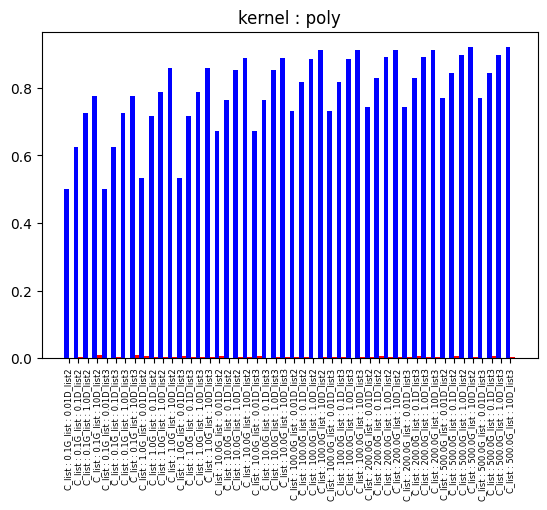

In [47]:
x = np.arange(len(bar_mean))
w = 0.5
fig,ax = plt.subplots()
fig = plt.title('kernel : poly')
rect1 = plt.bar(x-w/2,bar_mean,w,color = 'blue')
rect2 = plt.bar(x+w/2,bar_std,w,color = 'red')
ax.set_xticks(x,labels = bar_params,fontsize = 6,rotation = 90)
plt.subplots_adjust(bottom=0.20)
plt.show()